In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.preprocessing import ICA

from Cho2017 import SubjectData


plt.rcParams['figure.figsize'] = [12, 8]

# # Make sure ipympl is installed (via pip) for interactive plots in Jupyter 
# %matplotlib widget

In [2]:
subject = SubjectData('../Data/mat_data/s01.mat')

In [3]:
rej = {'eeg': 150e-6}

im_left_epochs = subject.get_epochs('imagery_left', tmin=-0.5, tmax=2, picks=['eeg'], reject_criteria=rej, verbose=False)
im_right_epochs = subject.get_epochs('imagery_right', tmin=-0.5, tmax=2, picks=['eeg'], reject_criteria=rej, verbose=False)

100 events found
Event IDs: [1]
100 events found
Event IDs: [1]


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 9.1s.


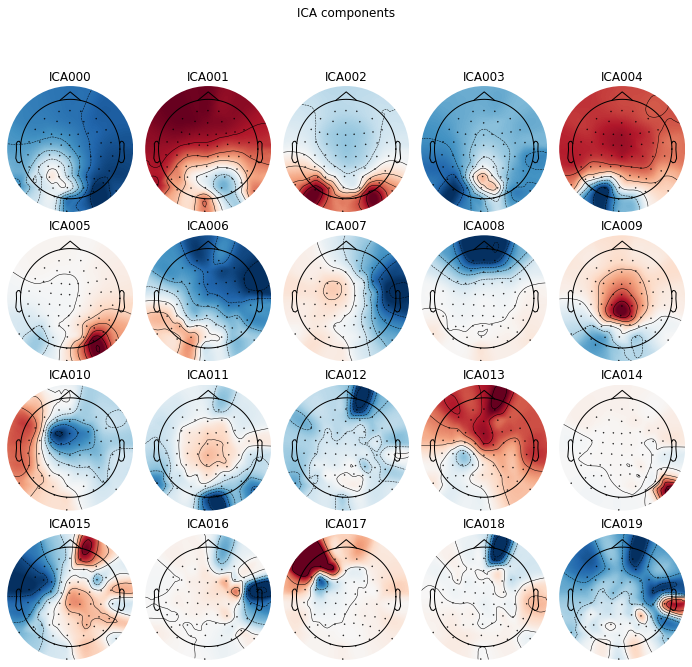

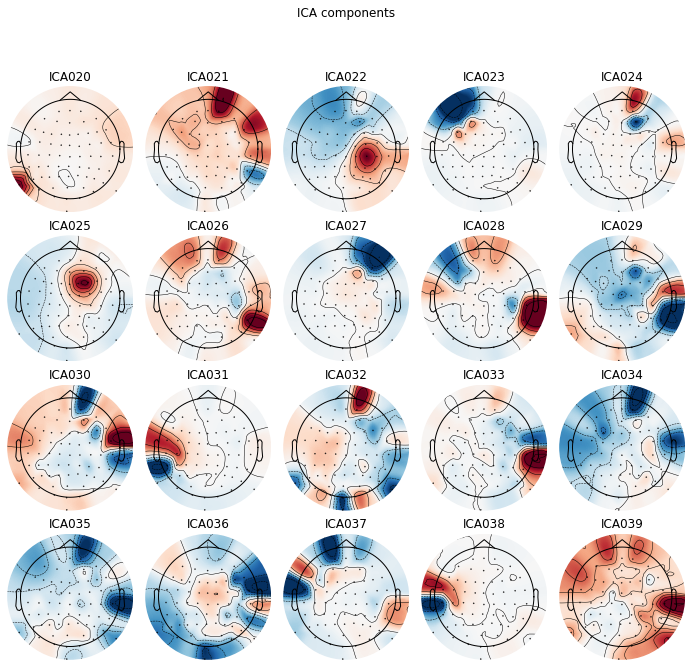

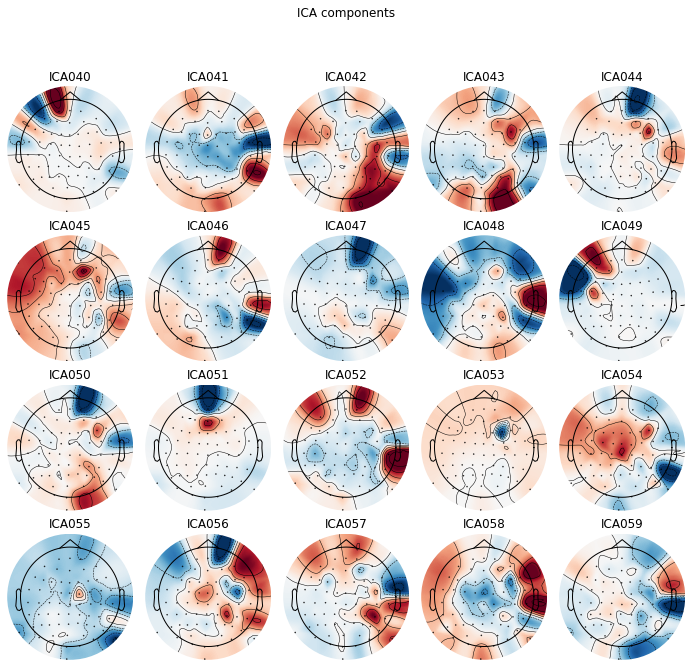

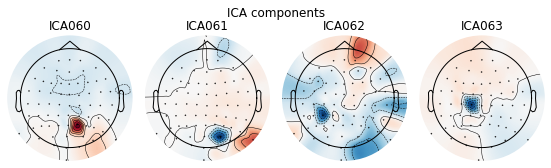

In [4]:
n_ica_comps = 64
ica = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
ica.fit(im_left_epochs)
# ica.plot_sources(im_left_epochs);
ica.plot_components();
# ica.plot_properties(im_left_epochs);

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not setting metadata
99 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


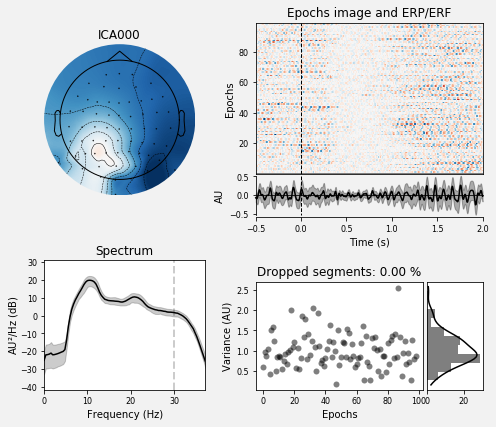

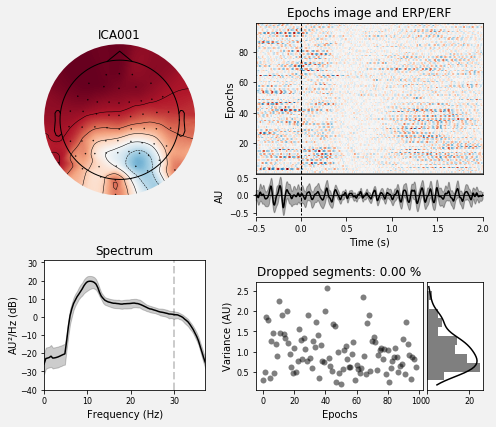

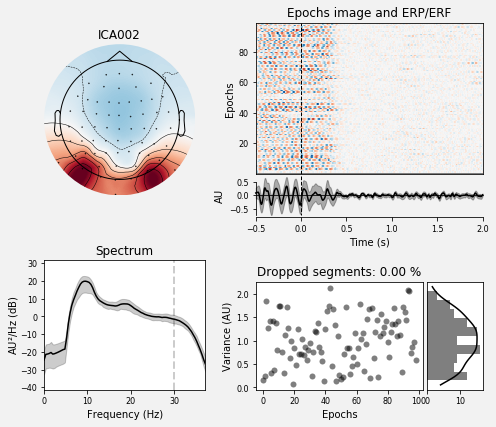

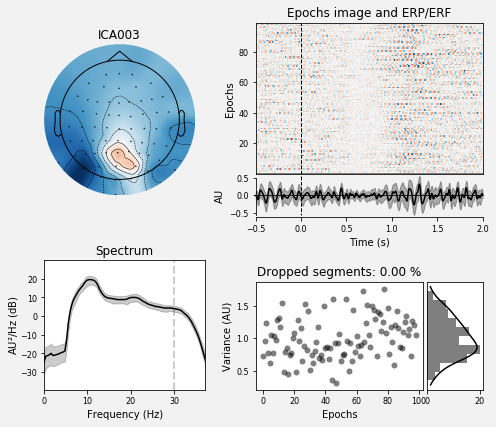

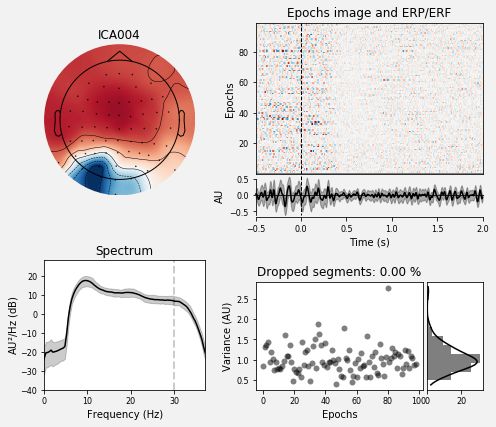

In [5]:
ica.plot_properties(im_left_epochs);

In [6]:
left_keep_comps = list(range(63))
ignore_comps = ignore_comps = list(filter(lambda i: i not in left_keep_comps, list(range(n_ica_comps))))
denoised_im_left_epochs = im_left_epochs.copy()
ica.apply(denoised_im_left_epochs, exclude=ignore_comps)

Transforming to ICA space (64 components)
Zeroing out 1 ICA component


<Epochs |  99 events (all good), -0.5 - 2 sec, baseline [None, 0], ~62.1 MB, data loaded,
 '1': 99>

In [7]:
# ica = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
# ica.fit(im_right_epochs)
# ica.plot_components();

In [8]:
# right_keep_comps = [0, 1, 2, 4]
right_keep_comps = left_keep_comps
# ignore_comps = list(filter(lambda i: i not in right_keep_comps, list(range(n_ica_comps))))
denoised_im_right_epochs = im_right_epochs.copy()
ica.apply(denoised_im_right_epochs, exclude=ignore_comps)

Transforming to ICA space (64 components)
Zeroing out 1 ICA component


<Epochs |  100 events (all good), -0.5 - 2 sec, baseline [None, 0], ~62.7 MB, data loaded,
 '1': 100>

In [9]:
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne.decoding import CSP

In [10]:
assert len(left_keep_comps) == len(right_keep_comps)

data = np.vstack((denoised_im_left_epochs.get_data(), denoised_im_right_epochs.get_data()))
# # Alternatively can try with ICA un-mixed sources rather than the denoised signal
source_left = ica.get_sources(im_left_epochs, start=0.5, stop=2.5)
source_right = ica.get_sources(im_right_epochs, start=0.5, stop=2.5)
data = np.vstack((source_right.get_data()[:, left_keep_comps, :], source_left.get_data()[:, right_keep_comps, :]))

labels = np.hstack((im_left_epochs.events[:, -1] - 1, im_right_epochs.events[:, -1]))  # Set left events to 0 to have 2 distinct class labels (left: 0 and right: 1)

In [11]:
data.shape

(199, 63, 1281)

In [12]:
scores = []
cv = ShuffleSplit(10, test_size=0.25, random_state=42)
cv_split = cv.split(data)

In [13]:
csp = CSP(n_components=2, reg=None, log=False, norm_trace=False)   # Cho 2017 uses 2 components
lda = LinearDiscriminantAnalysis()

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, data, labels, cv=cv, n_jobs=8, error_score='raise')

In [14]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

Classification accuracy: 0.576000 / Chance level: 0.502513


In [15]:
print(data.shape)
print(labels.shape, labels)
print(scores)

(199, 63, 1281)
(199,) [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.58 0.54 0.46 0.62 0.7  0.34 0.76 0.46 0.72 0.58]


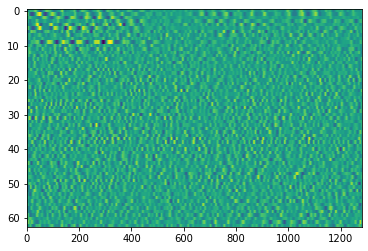

In [16]:
plt.imshow(data[3], aspect='auto')

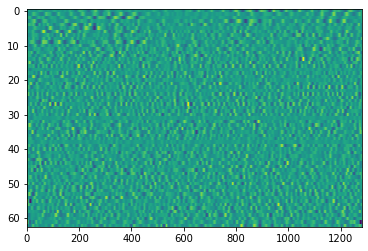

In [17]:
plt.imshow(data[-3], aspect='auto')

# Left/Right Joint Denoising

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 9.0s.


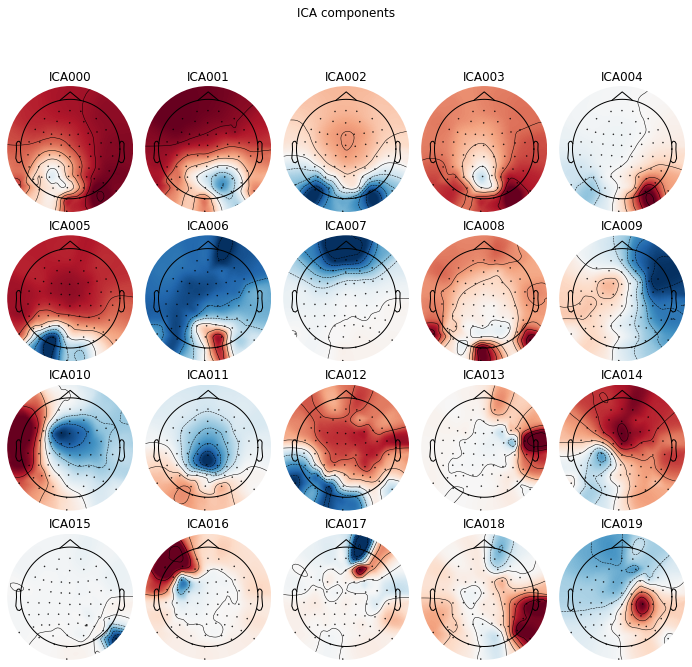

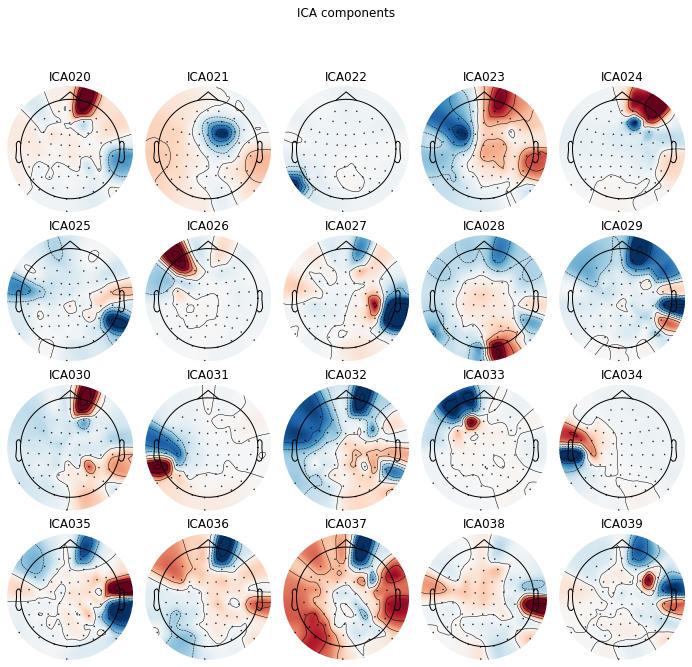

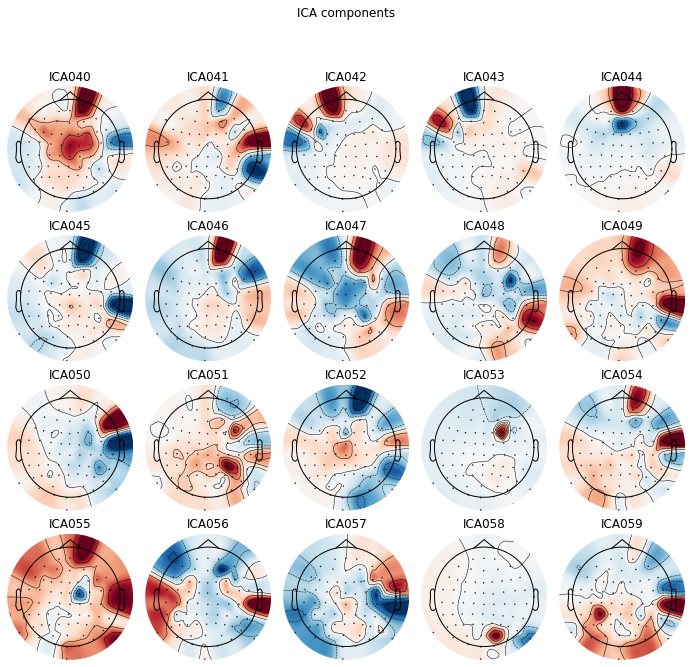

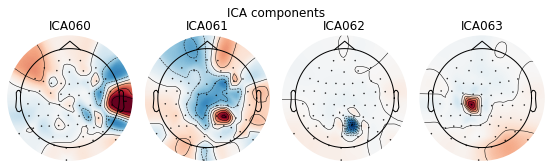

In [18]:
joint_im_epochs = mne.concatenate_epochs([im_left_epochs.copy(), im_right_epochs.copy()], add_offset=True)
labels = np.hstack((im_left_epochs.events[:, -1] - 1, im_right_epochs.events[:, -1]))  # Set left events to 0 to have 2 distinct class labels (left: 0 and right: 1)
ica = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
ica.fit(joint_im_epochs)
ica.plot_components();

In [23]:
joint_keep_comps = [0, 2]
ignore_comps = list(filter(lambda i: i not in joint_keep_comps, list(range(n_ica_comps))))
denoised_joint_im_epochs = joint_im_epochs.copy()
ica.apply(denoised_joint_im_epochs, exclude=ignore_comps)

Transforming to ICA space (64 components)
Zeroing out 62 ICA components


<Epochs |  199 events (all good), -0.5 - 2 sec, baseline [None, 0], ~124.6 MB, data loaded,
 '1': 199>

In [24]:
data = ica.get_sources(denoised_joint_im_epochs, start=0.5, stop=2.5).get_data()
# data = denoised_joint_im_epochs.get_data()

In [25]:
scores = []
cv = ShuffleSplit(10, test_size=0.25, random_state=42)
cv_split = cv.split(data)

csp = CSP(n_components=2, reg=None, log=False, norm_trace=False)   # Cho 2017 uses 2 components
lda = LinearDiscriminantAnalysis()

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, data, labels, cv=cv, n_jobs=8, error_score='raise')

class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [ ]:
print(data.shape)
print(labels.shape, labels)
print(scores)

In [ ]:
plt.imshow(data[3], aspect='auto')

In [ ]:
plt.imshow(data[-3], aspect='auto')

## Applying Corrmap from noise trial and the MI trials to find bad components

### jaw

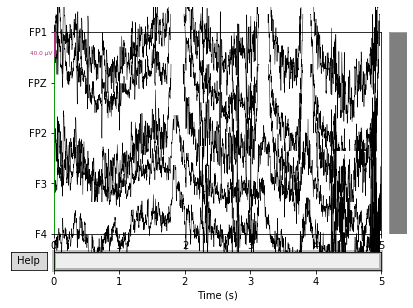

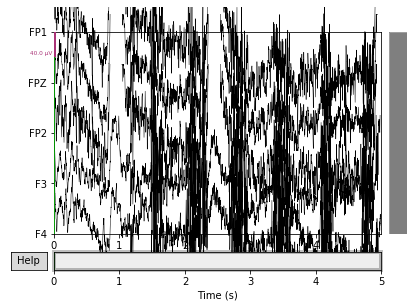

Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2561 samples (5.002 sec)

Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected : 5
Using channel FP1 as EOG channel
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-------------------

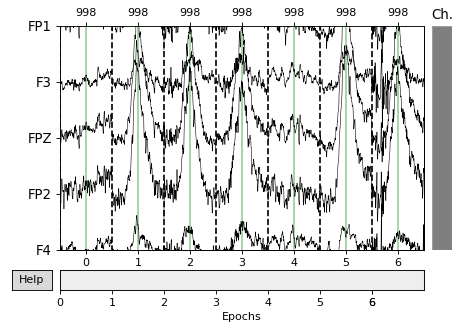

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by number: 64 components
Fitting ICA took 0.9s.


<ICA | epochs decomposition, fit (fastica): 1799 samples, 64 components, channels used: "eeg">

In [35]:
picks = ['FP1', 'FPZ', 'FP2', 'F3', 'F4'] # None / ['eeg'] for first 20 channels or list of channel names for those specified channels

# Since blinking is performed in 2x 5s trials, it's possible the discontinuity at the trial boundary may be falsely marked as an EOG
jaw = [subject.raw_noise['jaw'].copy().crop(tmin=0, tmax=5), subject.raw_noise['jaw'].copy().crop(tmin=5, tmax=None)]
jaw[0].copy().pick(picks).plot();
jaw[1].copy().pick(picks).plot();

from mne import concatenate_epochs
from mne.preprocessing import find_eog_events
find_eog_ch = 'FP1'
tmin = -0.25
tmax = 0.25
baseline_toffset = 0.01

trial0_jaw_events = find_eog_events(jaw[0], ch_name=find_eog_ch, filter_length=2561)    # Match filter length to length of signal
trial1_jaw_events = find_eog_events(jaw[1], ch_name=find_eog_ch, filter_length=2560)

trial0_jaw_epochs = mne.Epochs(jaw[0], trial0_jaw_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
trial1_jaw_epochs = mne.Epochs(jaw[1], trial1_jaw_events, tmin=tmin, tmax=tmax, baseline=(tmin, tmin+baseline_toffset), reject=None, preload=True)
# trial0_eye_up_down_epochs.plot(picks=picks);

jaw_epochs = concatenate_epochs([trial0_jaw_epochs, trial1_jaw_epochs])
jaw_epochs.plot(picks=picks);

from mne.preprocessing import ICA

n_ica_comps = 64
ica_jaw = mne.preprocessing.ICA(n_components=n_ica_comps, random_state=97, max_iter=1000)
ica_jaw.fit(jaw_epochs)
# ica_jaw.plot_sources(jaw_epochs);
# ica_jaw.plot_components();

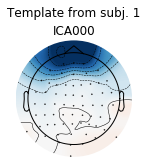

Median correlation with constructed map: 0.991
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


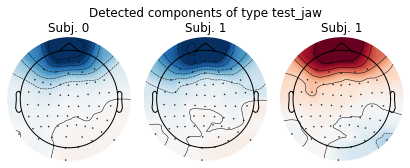

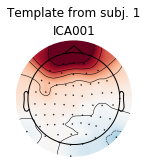

Median correlation with constructed map: 0.990
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


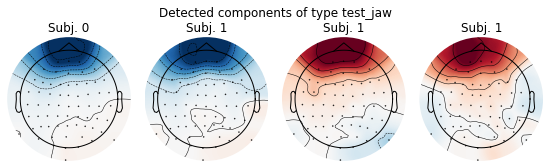

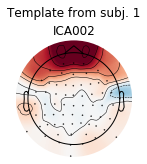

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


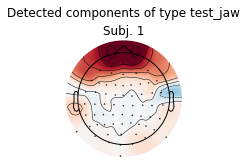

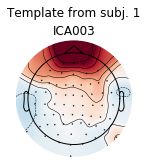

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


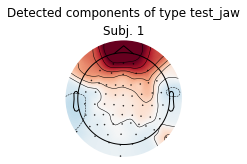

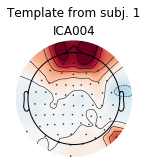

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


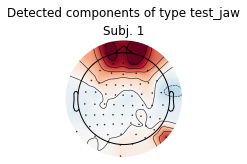

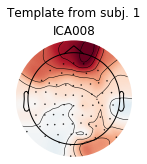

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


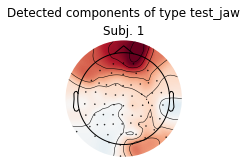

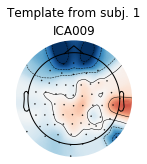

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


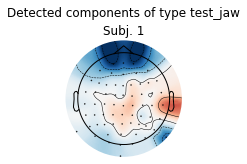

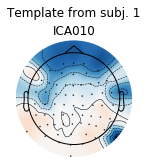

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


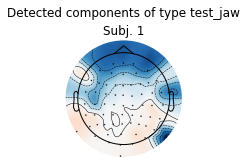

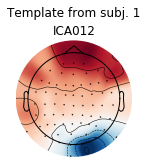

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


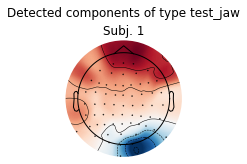

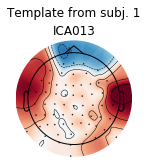

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


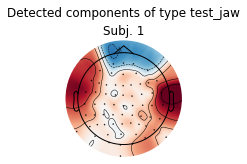

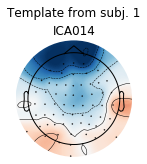

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


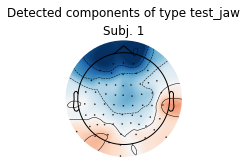

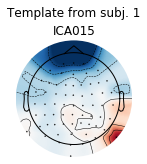

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


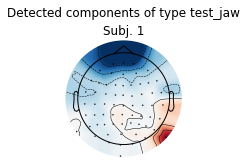

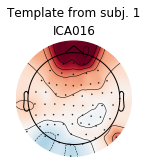

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


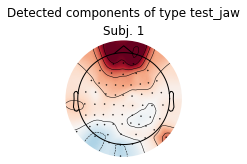

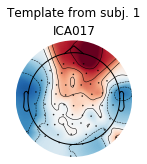

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


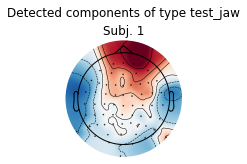

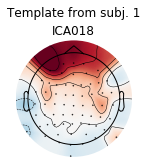

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


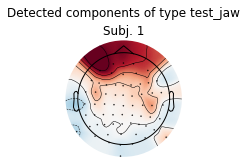

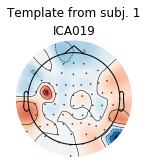

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


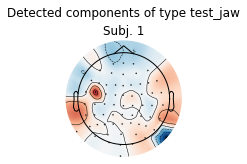

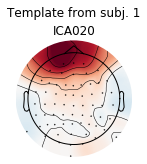

Median correlation with constructed map: 0.977
Displaying selected ICs per subject.
At least 1 IC detected for each subject.


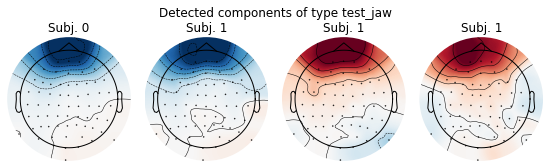

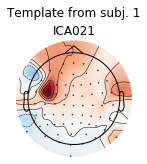

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


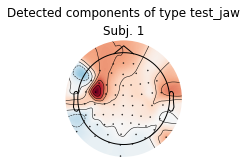

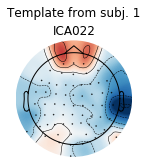

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


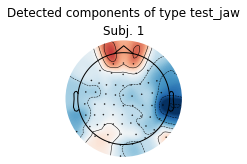

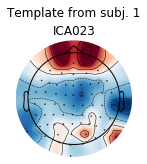

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


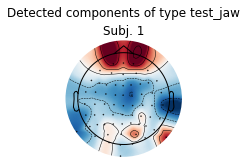

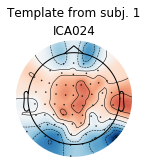

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


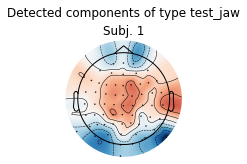

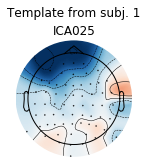

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


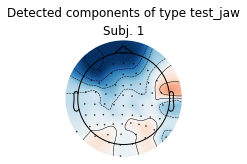

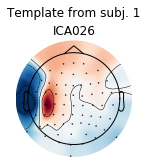

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


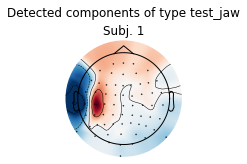

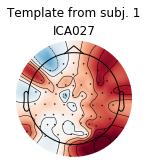

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


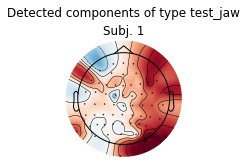

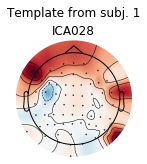

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


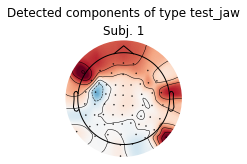

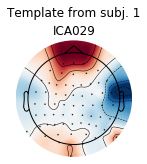

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


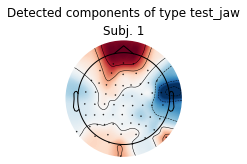

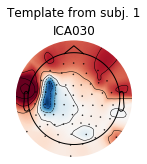

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


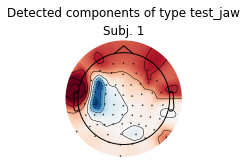

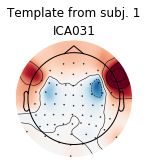

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


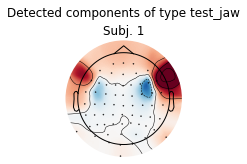

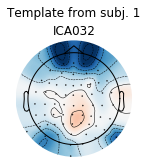

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


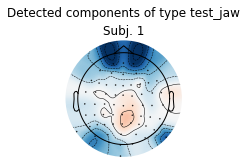

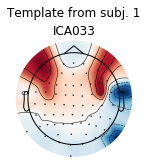

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


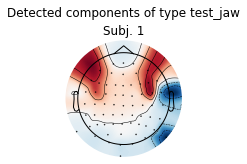

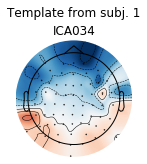

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


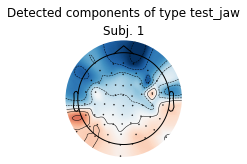

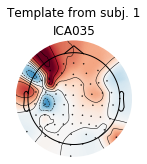

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


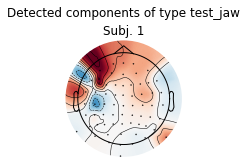

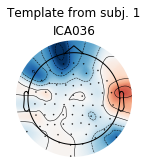

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


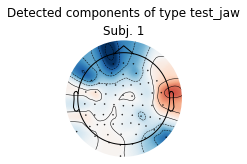

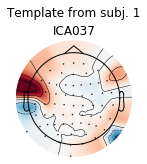

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


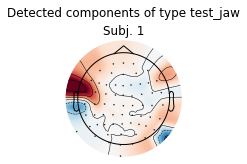

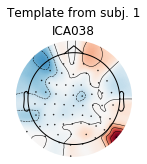

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


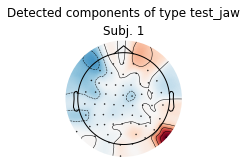

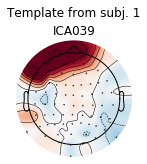

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


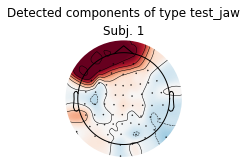

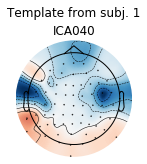

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


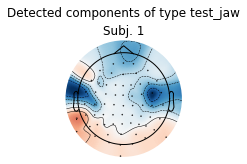

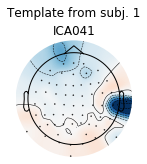

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


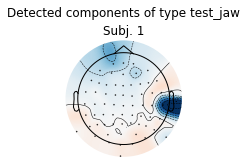

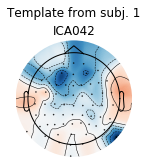

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


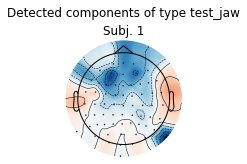

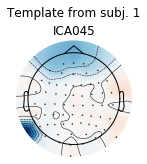

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


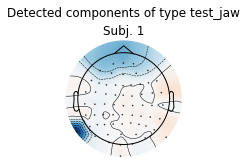

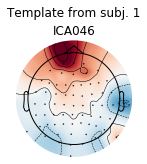

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


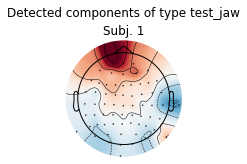

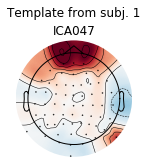

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


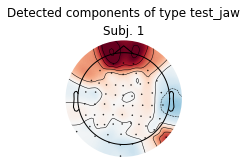

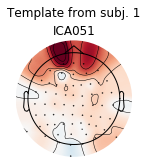

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


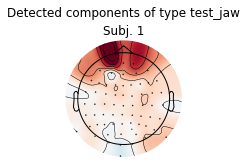

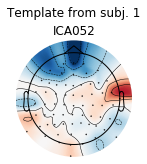

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


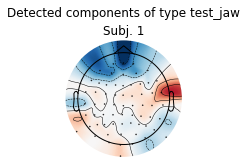

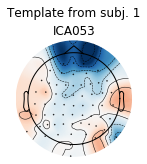

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


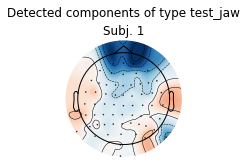

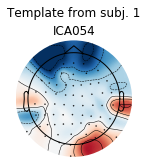

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


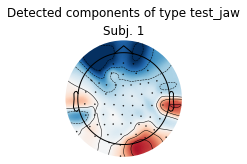

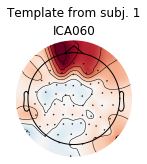

Median correlation with constructed map: 1.000
Displaying selected ICs per subject.
No maps selected for subject [0], consider a more liberal threshold.


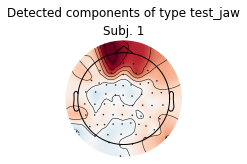

In [36]:
from mne.preprocessing import corrmap
# jaw
ica_jaw_excludes = [5, 6, 7, 11, 43, 44, 48, 49, 50, 55, 56, 57, 58, 59, 61, 62, 63]

for i in range(63):
    if i not in ica_jaw_excludes:
        corrmap([ica, ica_jaw], (1, i), label='test_jaw');

In [37]:
ica.labels_['test_jaw']

[7]